In [1]:
import torch
import torch.nn as nn

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        """ 旋转位置编码
            - dim (int): 旋转嵌入的维度大小。
            - max_position_embeddings (int): 预计算的最大位置嵌入数，默认为2048。
            - base (int): 用于计算逆频率的基本频率，默认为10000。
        """
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        # 计算逆频率值，并将其注册为模型的缓冲区
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # 为了支持`torch.jit.trace`功能，立即计算预存储的余弦和正弦缓存
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        """ 预计算的余弦和正弦缓存
        """
        self.max_seq_len_cached = seq_len
        # 创建一个从0到最大序列长度-1的整数张量，与 inv_freq 具有相同的设备和数据类型
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=torch.int64).type_as(self.inv_freq)

        # 计算每个位置与每个维度的频率，形成频谱矩阵
        freqs = torch.outer(t, self.inv_freq)
        
        # 不同于论文中的实现，这里采用了不同的排列方式以获得相同的计算结果
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )

def rotate_half(x):
    """ 旋转输入一半的 hidden dim
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.mistral.modeling_mistral.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """ 在 qk 应用旋转位置编码

    Args:
        q (`torch.Tensor`): q
        k (`torch.Tensor`): k
        cos (`torch.Tensor`): 旋转位置嵌入的余弦部分
        sin (`torch.Tensor`): 旋转位置嵌入的正弦部分
        position_ids (`torch.Tensor`): 与q和k对应位置的标记索引。例如，在处理KV缓存时，可以使用偏移过的位置ID。
        unsqueeze_dim (`int`, *optional*, defaults to 1): 'unsqueeze_dim' 参数指定了沿哪个维度对 cos[position_ids] 
            和 sin[position_ids] 进行扩展，以便它们能够适当地广播到 q 和 k 的维度上。
            例如，注意 cos[position_ids] 和 sin[position_ids] 具有形状 [batch_size, seq_len, head_dim]。
            那么，如果 q 和 k 的形状分别为 [batch_size, heads, seq_len, head_dim]，
            则设置 unsqueeze_dim=1 可使 cos[position_ids] 和 sin[position_ids] 可以广播到 q 和 k 的形状上。
            同样地，如果 q 和 k 的形状为 [batch_size, seq_len, heads, head_dim]，则应将 unsqueeze_dim 设置为 2
    Returns:
        包含使用旋转位置嵌入变换后的q和k张量的 `tuple(torch.Tensor)`。
    """
    # print("ori cos: ", cos.shape)
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    # print("q: ", q.shape)
    # print("cos: ", cos.shape)
    # print("sin: ", sin.shape)
    # print("rotate_half: ", rotate_half(q).shape)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [ ]:
q, k = torch.randn(4, 4, 12, 16), torch.randn(4, 4, 6, 16) # (bs, n_head, seq_len, n_dim)
rotary_emb = TinyllmRotaryEmbedding(dim=16)
cos, sin = rotary_emb(q, seq_len=4)
q, k = apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=2)
q.shape, k.shape

In [ ]:
torch.randn(12, 16)[None].unsqueeze(1).shape

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from pretrain import load_model_tokenizer


tokenizer, model = load_model_tokenizer(tokenizer_name='Qwen/Qwen3-0.6B', seq_len=1024, device=device)

In [ ]:
from pretrain import sample
sample(tokenizer, model, '中国首都是哪?')

In [ ]:
ds = load_dataset(tokenizer, num_proc=args.ds_num_proc, seq_len=args.block_size)

In [ ]:
import torch

torch.tensor([2, 4]).ne(2)

In [ ]:
"12121333".split('<|start|>assistant', maxsplit=1)

In [ ]:
from transformers import AutoTokenizer
from trl import DataCollatorForCompletionOnlyLM

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# print(tokenizer.max_length)
# Example messages
messages = [
    {"role": "system", "content": "You are a helpful assistant?"},
    {"role": "user", "content": "Hi, who are you?"},
    {"role": "assistant", "content": "I'm an AI assistant."},
    {"role": "user", "content": "What's your job?"},
    {"role": "assistant", "content": "Helping humans solve problems."}
]

# Convert to tokenized input
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True,  enable_thinking=False)

print(prompt)
# # Tokenize
tokenized = tokenizer(prompt, return_tensors="pt", padding=True)

# Create a batch format expected by the collator
batch = [{
    "input_ids": tokenized["input_ids"][0],
    "attention_mask": tokenized["attention_mask"][0]
}]

# Use the collator to mask non-assistant tokens
collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer,
    instruction_template="<|im_start|>user",  # 开始 loss 的位置
    response_template="<|im_start|>assistant",  # 如果你想从 assistant 开始一直算 loss，可以省略
    mlm=False,
)

collated = collator(batch)

# Show input_ids and labels (masked)
print("\n🔹 Tokens:")
print([tokenizer.decode([id]) for id in collated['input_ids'][0]])

print("\n🔹 Labels (for loss):")
for token_id, label_id in zip(collated["input_ids"][0], collated["labels"][0]):
    token = tokenizer.decode([token_id.item()])
    label = tokenizer.decode([label_id.item()]) if label_id != -100 else "MASKED"
    print(f"{token!r:20} -> {label!r}")
    

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Example chat
messages = [
    {"role": "user", "content": "What is AI?"},
    {"role": "assistant", "content": "AI stands for Artificial Intelligence."}
]

# Apply template and tokenize directly
out = tokenizer.apply_chat_template(
    messages,
    tokenize=True,            # 🔸 This returns tokenized output (not a string)
    return_tensors="pt"       # 🔸 This returns PyTorch tensors
)

print(out)                 # <class 'transformers.tokenization_utils_base.BatchEncoding'>
# print(out.keys())               # dict_keys(['input_ids', 'attention_mask'])
print(out["input_ids"][0].shape)   # e.g., torch.Size([1, 50])
print(tokenizer.decode(out["input_ids"][0]))  # Decode to see result

In [1]:
import torch
import torch.nn as nn

hidden_size = 32
intermediate_size = 128

gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
act_fn = nn.SiLU()

In [5]:
x = torch.randn(1, 2, 2, 32)

g = act_fn(gate_proj(x))
u = g * up_proj(x)
u.shape

torch.Size([1, 2, 2, 128])

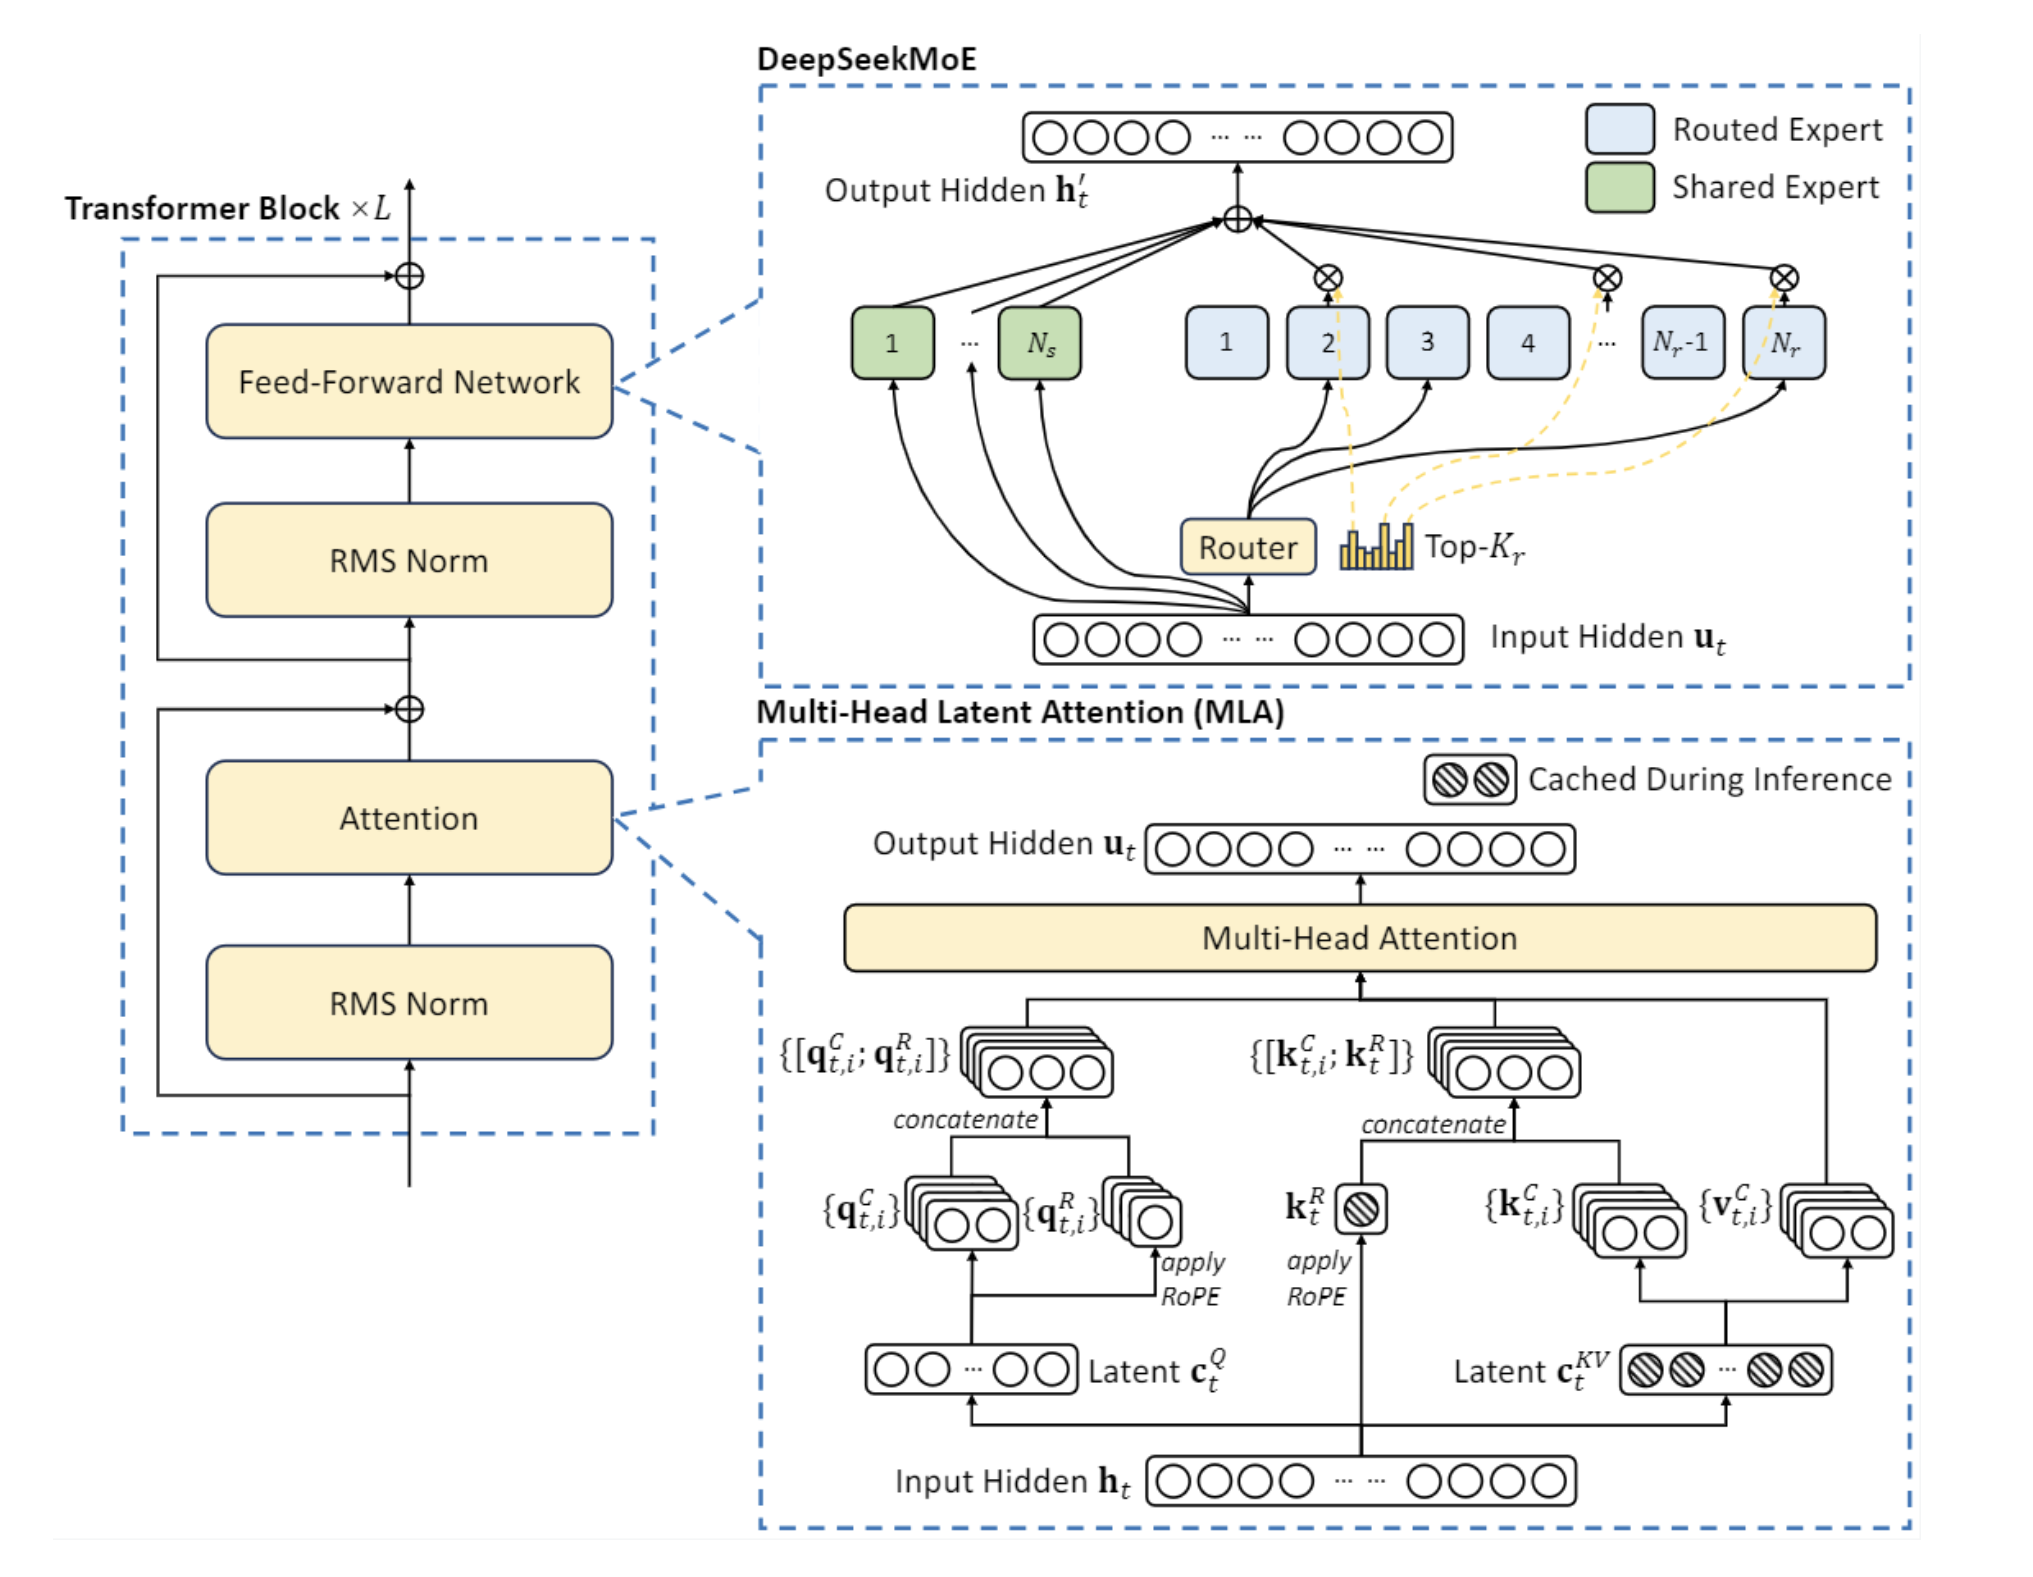

In [10]:
from IPython.core.display import Image

Image('../static/deepseek-v3-model-architecture.png')

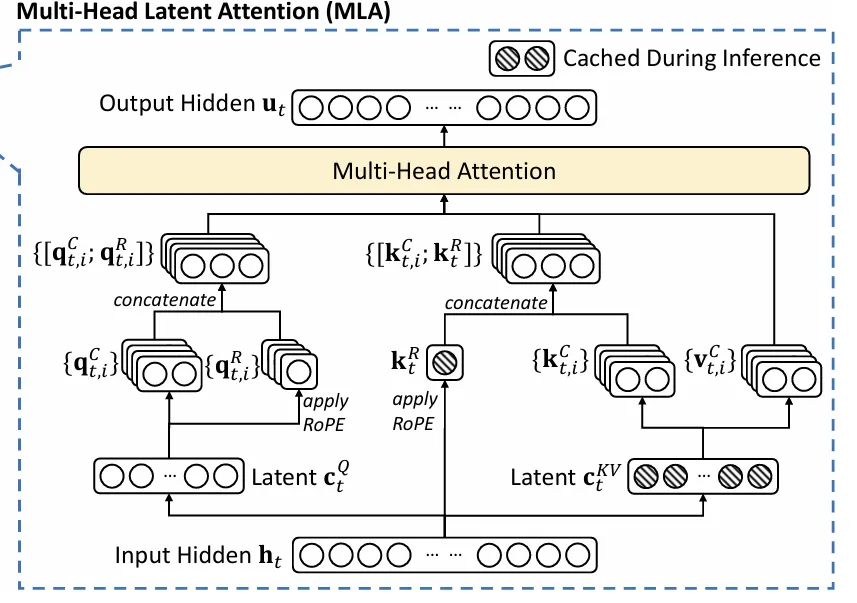

In [3]:
from IPython.core.display import Image

Image('mla.webp')

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from typing import Optional
from transformers.cache_utils import Cache, DynamicCache

class MLA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_embed = config.hidden_size
        self.n_head = config.num_attention_heads

        self.rope_emb = RotaryEmbedding(config.qk_rope_head_dim)

        self.q_lora_rank = config.q_lora_rank
        self.qk_rope_head_dim = config.qk_rope_head_dim

        self.kv_lora_rank = config.kv_lora_rank

        self.v_head_dim = config.v_head_dim

        self.qk_nope_head_dim = config.qk_nope_head_dim

        self.q_head_dim = self.qk_nope_head_dim + self.qk_rope_head_dim

        # q latent proj
        self.q_down_proj = nn.Linear(self.n_embed, self.q_lora_rank, bias=False)
        self.q_down_layernorm = nn.RMSNorm(self.q_lora_rank)
        self.q_up_proj = nn.Linear(self.q_lora_rank, self.n_head * self.q_head_dim, bias=False)

        # kv latent proj
        self.kv_down_proj = nn.Linear(self.n_embed, self.kv_lora_rank + self.qk_rope_head_dim, bias=False)
        self.kv_down_layernorm = nn.RMSNorm(self.kv_lora_rank)
        self.kv_up_proj = nn.Linear(self.kv_lora_rank, self.n_head * (self.qk_nope_head_dim + self.v_head_dim), bias=False)

        self.o_proj = nn.Linear(self.n_head * self.v_head_dim, self.n_embed, bias=False)

    def forward(
        self, 
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
    ):
        bsz, q_len, _ = hidden_states.size()

        q = self.q_down_proj(hidden_states)
        q = self.q_down_layernorm(q)
        q = self.q_up_proj(q)
        q = q.view(bsz, q_len, self.n_head, self.q_head_dim).transpose(1, 2)
        q_nope, q_rope = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
        compress_kv = self.kv_down_proj(hidden_states)
        # print('compress_kv', compress_kv.shape)
        compress_kv, k_rope = torch.split(compress_kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
        k_rope = k_rope.view(bsz, seq_len, 1, self.qk_rope_head_dim).expand(bsz, seq_len, n_head, self.qk_rope_head_dim).transpose(1, 2)
        kv = self.kv_up_proj(self.kv_down_layernorm(compress_kv)).view(bsz, seq_len, n_head, self.qk_nope_head_dim + self.v_head_dim).transpose(1, 2)
        k_nope, value_states = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim=-1)

        kv_seq_len = value_states.shape[-2] # bsz, n_head, q_len, v_head_dim

        cos, sin = self.rope_emb(value_states, seq_len=kv_seq_len)

        q_rope, k_rope = apply_rotary_pos_emb(q_rope, k_rope, cos, sin)

        # print('q_nope', q_nope.shape, 'q_rope', q_rope.shape)
        # print('k_nope', k_nope.shape, 'k_rope', k_rope.shape)
        query_states = torch.cat([q_nope, q_rope], dim=-1) # bsz, n_head, q_len, q_head_dim
        key_states = torch.cat([k_nope, k_rope], dim=-1) # bsz, n_head, q_len, q_head_dim

        # compute attention weights
        # attn_weights = torch.matmul(query_states, key_states.transpose(2,3)) # bsz, n_head, q_len, q_len
        # attn_weights = attn_weights / self.q_head_dim ** 0.5

        # attn_weights = F.softmax(attn_weights, dim=-1) # bsz, n_head, q_len, q_len
        # attn_output = attn_weights @ value_states 
        # attn_output = attn_output.transpose(1, 2).reshape(bsz, q_len, -1) # bsz, q_len, n_head * v_head_dim
        # 使用scaled_dot_product_attention进行计算
        attn_output = F.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            attn_mask=attention_mask,
            # The q_len > 1 is necessary to match with AttentionMaskConverter.to_causal_4d that does not create a causal mask in case q_len == 1.
            is_causal=attention_mask is None and q_len > 1,
        )  # bsz, q_len, n_head * v_head_dim
        print(query_states.shape, key_states.shape, value_states.shape, attn_output.shape)
        attn_output = self.o_proj(attn_output.reshape(bsz, q_len, -1)) # bsz, q_len, n_embed
        
        
        return attn_output, None, past_key_value
        
        

In [38]:
import sys
sys.path.append('..')  # Make sure project root is in the path
from model.configuration_buddygpt import BuddyGPTConfig

n_embed = 10
n_layer = 1
n_head = 2
n_kv_head = 1
seq_len = 10
config = BuddyGPTConfig(
    vocab_size=-1,
    hidden_size=n_embed,
    intermediate_size=n_embed * 2,
    num_hidden_layers=n_layer,
    num_attention_heads=n_head,
    num_key_value_heads=n_kv_head,
    num_seq_len=seq_len,
    q_lora_rank=16,
)
mla = MLA(config)

In [39]:
mla

MLA(
  (rope_emb): RotaryEmbedding()
  (q_down_proj): Linear(in_features=10, out_features=16, bias=False)
  (q_down_layernorm): RMSNorm((16,), eps=None, elementwise_affine=True)
  (q_up_proj): Linear(in_features=16, out_features=32, bias=False)
  (kv_down_proj): Linear(in_features=10, out_features=20, bias=False)
  (kv_down_layernorm): RMSNorm((16,), eps=None, elementwise_affine=True)
  (kv_up_proj): Linear(in_features=16, out_features=56, bias=False)
  (o_proj): Linear(in_features=32, out_features=10, bias=False)
)

In [40]:
x = torch.randn(4, seq_len, n_embed)
attn_output, attn_weights, _ = mla(x)
attn_output.shape

torch.Size([4, 2, 10, 16]) torch.Size([4, 2, 10, 16]) torch.Size([4, 2, 10, 16]) torch.Size([4, 2, 10, 16])


torch.Size([4, 10, 10])

In [23]:
import torch

a, b = torch.randn(2, 2, 4), torch.randn(2, 2, 4)
torch.cat([a, b], dim=-1).shape

torch.Size([2, 2, 8])

In [43]:
k_nope = torch.randn(2, 2, 4)
k_rope = torch.randn(2, 1, 4)
print(k_nope, k_rope)
key_states = torch.empty(
    2, 2, 8
)
key_states[:, :, :4] = k_nope
key_states[:, :, 4:] = k_rope

key_states

tensor([[[-0.5036,  0.7794, -0.1988,  0.8124],
         [-0.0025, -0.3225,  0.7481,  0.0657]],

        [[ 1.4685,  0.8313, -1.6261, -0.3989],
         [ 0.1947, -0.1304, -0.5323, -0.9557]]]) tensor([[[ 0.1699,  0.9864, -0.0235,  1.3911]],

        [[-0.2139, -0.3007,  1.1695, -0.2471]]])


tensor([[[-0.5036,  0.7794, -0.1988,  0.8124,  0.1699,  0.9864, -0.0235,
           1.3911],
         [-0.0025, -0.3225,  0.7481,  0.0657,  0.1699,  0.9864, -0.0235,
           1.3911]],

        [[ 1.4685,  0.8313, -1.6261, -0.3989, -0.2139, -0.3007,  1.1695,
          -0.2471],
         [ 0.1947, -0.1304, -0.5323, -0.9557, -0.2139, -0.3007,  1.1695,
          -0.2471]]])

In [43]:
1 if False else (2 if True else 3)

2